In [2]:
!git clone https://github.com/Hinoto04/2021_PNUAC_AIData.git

Cloning into '2021_PNUAC_AIData'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 145 (delta 45), reused 21 (delta 21), pack-reused 79
Receiving objects: 100% (145/145), 28.86 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (56/56), done.


스마트워치를 착용하여 6개월 동안 수집된 데이터셋을 활용하여 간단한 신경망을 이용하여 예측 모델을 만들어보겠습니다.

데이터셋에 포함된 특성들은 다음과 같습니다.

* 날짜
* 칼로리 소모량
* 걸음 수
* 이동 거리
* 층수
* 정적인 시간(분)
* 약간 활동적인 시간(분)
* 상당히 활동적인 시간(분)
* 매우 활동적인 시간(분)
* 활동 칼로리

먼저 데이터를 판다스 패키지로 읽어보겠습니다.

In [3]:
import pandas as pd

df = pd.read_csv('/content/2021_PNUAC_AIData/data/fitbit_export_2021.csv', thousands = ',')

In [4]:
print(df.columns)

Index(['날짜', '칼로리 소모량', '걸음 수', '이동 거리', '층수', '정적인 시간(분)', '약간 활동적인 시간(분)',
       '상당히 활동적인 시간(분)', '매우 활동적인 시간(분)', '활동 칼로리'],
      dtype='object')


In [5]:
print(df)

               날짜  칼로리 소모량   걸음 수  ...  상당히 활동적인 시간(분)  매우 활동적인 시간(분)  활동 칼로리
0    2021. 1. 29.     2230   6304  ...               0              0     726
1    2021. 1. 30.     2883  13187  ...              26             25    1639
2    2021. 1. 31.     2756  12702  ...              14              8    1535
3     2021. 2. 1.     2674   9775  ...              13              9    1299
4     2021. 2. 2.     1667    538  ...               0              0     124
..            ...      ...    ...  ...             ...            ...     ...
120  2021. 6. 12.     2740  14267  ...              24              9    1536
121  2021. 6. 13.     1657   1073  ...               0              0     136
122  2021. 6. 14.     2435   9433  ...               6             22     987
123  2021. 6. 15.     1943   3492  ...               7             12     412
124  2021. 6. 16.     2063   4232  ...               6              2     608

[125 rows x 10 columns]


### 단층 퍼셉트론 신경망

먼저 단층 퍼셉트론 신경망 모델을 실습하기 위해, 걸음 수를 입력하면 이동 거리를 예측하는 간단한 모델을 만들어보겠습니다. 

다음과 같이 모델 입출력을 구성합니다.
- X: 걸음 수
- Y: 이동 거리

다음과 같이 데이터셋을 구성합니다.
- 훈련셋: 1번째 ~ 100번째 샘플
- 시험셋: 101번째 ~ 125번째 샘플

In [6]:
x = df['걸음 수']
y = df['이동 거리']

x_train = x[:100]
y_train = y[:100]
x_test = x[100:]
y_test = y[100:]

걸음 수를 입력하면 이동 거리를 구하는 모델이기 때문에, 테스트로 입력할 걸음 수 정보를 먼저 확인해봅니다. 우리는 인공지능 모델이 아래 걸음 수를 입력했을 때, 적정한 이동 거리를 구하기를 희망하는 것입니다.

In [7]:
print(x_test)

100     6771
101     8225
102     3853
103     7625
104      377
105     3921
106     9740
107     5761
108     6214
109     4089
110     6325
111     8123
112    10884
113    13917
114    13917
115     6885
116     7629
117     6104
118     3590
119     1897
120    14267
121     1073
122     9433
123     3492
124     4232
Name: 걸음 수, dtype: int64


위의 문제를 풀기 위해, 과거 데이터로 패턴을 익힌 후 사용할 수 있는 모델을 만들어보겠습니다. 먼저 과거 데이터 즉 훈련셋을 살펴보겠습니다.

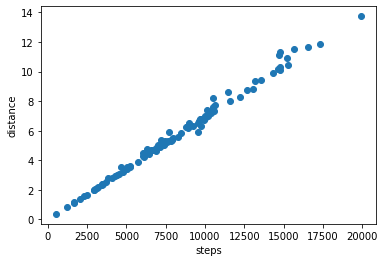

In [8]:
import matplotlib.pyplot as plt

plt.scatter(x_train, y_train)
plt.xlabel('steps')
plt.ylabel('distance')
plt.show()

'걸음 수'와 '이동 거리'는 서로 비례 관계를 가지고 있습니다. 이런 패턴은 선형회귀 문제로 풀 수 있으며, 여러가지 모델이 있으나 가장 간단한 단층 퍼셉트론 신경망으로 풀어보겠습니다. 

케라스를 사용하기 위해 필요한 패키지를 가져옵니다.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

"Y = w * X + b"에서 주어진 X, Y에 대해 학습에 의해 갱신될 가중치(w) 하나와 바이어스(b)를 하나를 가진 네트워크 아키텍처를 정의합니다.

In [10]:
model = Sequential([
    Dense(1, input_dim=1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


손실함수는 회귀문제에 적합한 'mse'로 설정하고, 최적화기(optimizer)는 'rmsprop'으로 설정하여 모델을 컴파일 합니다. 평가 매트릭은 수치 차이를 직관적으로 알 수 있도록 'mae'로 설정했습니다.

In [11]:
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

모델을 학습하기 위해 준비한 훈련셋으로 학습을 시작합니다. 반복횟수(epochs)는 100번으로 배치사이즈는 4로 설정했습니다.

In [12]:
model.fit(x_train, y_train, epochs=100, batch_size=4)

Epoch 1/100
25/25 [==============================] - 3s 2ms/step - loss: 62717288.0000 - mae: 7108.4282
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 59209424.0000 - mae: 6912.1519
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 56098656.0000 - mae: 6724.2583
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 52979820.0000 - mae: 6537.8579
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 50023876.0000 - mae: 6349.6533
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 47279524.0000 - mae: 6172.8926
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 44569156.0000 - mae: 5992.0049
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 41777036.0000 - mae: 5803.9189
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 39203008.0000 - mae: 5620.1392
Epoch 10/100
25/25 [==============================] - 0s 2ms/ste

학습 과정 중에 평가 매트릭인 mae이 3이하로 나온다면, 훈련셋에 대해 실제값과 예측값 사이의 오차가 3km 이하라고 보시면 됩니다. get_weights() 함수를 사용하여 학습된 가중치와 바이어스를 살펴볼 수 있습니다.

In [13]:
w, b = model.get_weights()

print(w, b)

[[0.00069292]] [0.88190085]


이렇게 학습된 모델을 사용해보겠습니다. 10,000보를 걸었을 경우, 실제 이동거리는 얼마나 될까요? 

In [14]:
x_pred = [[10000]]
y_pred = model.predict(x_pred)
print(y_pred)

[[7.8110595]]


앞서 우리가 정의한 시험셋에 대해 평가하기 위해 25개 샘플의 "걸음 수"를 모델에 입력하여 "이동 거리"를 예측해봅니다. 


'mae'로 정량적으로 평가하기 위해 evaluate() 함수에 x_test와 y_test을 입력하면, 모델 출력과 y_test를 컴파일 시에 지정한 metric에 의해 계산된 값을 반환합니다. 이를 출력하면 시험셋에 대한 모델의 정확도를 구할 수 있습니다.

In [15]:
y_pred = model.predict(x_test)

print(y_pred)

loss, mae = model.evaluate(x_test, y_test)

print(mae)

[[ 5.573634 ]
 [ 6.581134 ]
 [ 3.5517056]
 [ 6.1653843]
 [ 1.1431301]
 [ 3.598824 ]
 [ 7.6309013]
 [ 4.8737893]
 [ 5.18768  ]
 [ 3.7152338]
 [ 5.2645936]
 [ 6.5104566]
 [ 8.423597 ]
 [10.525211 ]
 [10.525211 ]
 [ 5.6526265]
 [ 6.168156 ]
 [ 5.1114593]
 [ 3.3694687]
 [ 2.1963623]
 [10.767732 ]
 [ 1.6253996]
 [ 7.418176 ]
 [ 3.301563 ]
 [ 3.8143208]]
1/1 [==============================] - 0s 126ms/step - loss: 0.8405 - mae: 0.9150
0.9150300025939941


마지막으로 실제값과 모델의 예측값을 가시화 시켜서 어느정도 차이가 나는 지 확인해보겠습니다.

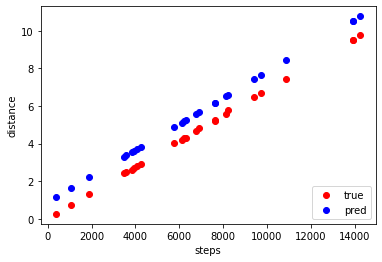

In [16]:
plt.scatter(x_test, y_test, c = 'r', label='true')
plt.scatter(x_test, y_pred, c = 'b', label='pred')

plt.xlabel('steps')
plt.ylabel('distance')
plt.legend(loc='lower right')

plt.show()

### 다층 퍼셉트론 신경망

다층 퍼셉트론 신경망 모델을 실습하기 위해, 조금 더 복잡한 문제를 풀어보겠습니다. 걸음 수, 이동 거리, 심박수를 입력하면, 칼로리 소모량을 예측하는 것입니다. 

다음과 같이 모델 입출력을 구성합니다.
- X
    - 걸음 수
    - 이동 거리
    - 정적인 시간(분)
    - 약간 활동적인 시간(분)
    - 상당히 활동적인 시간(분)
    - 매우 활동적인 시간(분)
- Y
    - 칼로리 소모량

다음과 같이 데이터셋을 구성합니다.
- 훈련셋: 1번째 ~ 100번째 샘플
- 시험셋: 101번째 ~ 125번째 샘플

In [17]:
x = df[['걸음 수', '이동 거리', '정적인 시간(분)', '약간 활동적인 시간(분)', '상당히 활동적인 시간(분)', '매우 활동적인 시간(분)']]
y = df['칼로리 소모량']

x_train = x[:100]
y_train = y[:100]
x_test = x[100:]
y_test = y[100:]

여러 개의 속성을 입력하여 칼로리 소모량을 구하는 모델이기 때문에, 테스트로 입력할 속성 정보를 먼저 확인해봅니다. 우리는 인공지능 모델이 아래 속성들을 입력했을 때, 적정한 칼로리 소모량을 구하기를 희망하는 것입니다.

In [18]:
print(x_test)

      걸음 수  이동 거리  정적인 시간(분)  약간 활동적인 시간(분)  상당히 활동적인 시간(분)  매우 활동적인 시간(분)
100   6771   4.68       1247            149              24             20
101   8225   5.81       1269            120              16             35
102   3853   2.62       1309            122               3              6
103   7625   5.20       1146            187               8             18
104    377   0.26       1371             14               0              0
105   3921   2.68       1373             40               5             22
106   9740   6.68       1229            192               4             15
107   5761   4.05       1304            136               0              0
108   6214   4.28       1276            154               1              9
109   4089   2.80       1261            179               0              0
110   6325   4.30       1281            149               5              5
111   8123   5.58       1153            172               9             18
112  10884   7.44       1

모델 구성에 앞서 딥러닝 모델이 잘 학습할 수 있도록 입력 데이터의 전처리를 수행합니다. 속성별로 상이한 스케일을 가진 데이터를 입력하면 스케일이 큰 속성에 영향을 많이 미치는 경우가 발생하기 때문에, 이 경우 정규화 과정을 거치게 됩니다. 속성별로 평균을 구한 뒤, 각 인스턴스에다 평균을 빼고 표준 편차로 나누겠습니다. 

시험셋을 입력할 때, 즉 모델을 학습 후에 사용할 때도 동일하게 정규화를 시켜야하므로, 훈련셋에서 구한 평균과 표준 편차를 기억해둡니다.

In [19]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std

print(mean)
print(std)

걸음 수              8166.280
이동 거리                5.718
정적인 시간(분)          992.050
약간 활동적인 시간(분)      207.990
상당히 활동적인 시간(분)      11.820
매우 활동적인 시간(분)       16.050
dtype: float64
걸음 수              4021.631183
이동 거리                2.854176
정적인 시간(분)          242.142390
약간 활동적인 시간(분)       82.894419
상당히 활동적인 시간(분)      13.810682
매우 활동적인 시간(분)       16.014119
dtype: float64


입력 속성이 6개이고 출력이 1개인 네트워크 아키텍처를 설계합니다. 비선형 문제를 풀 수 있도록 'relu'활성화 함수를 가진 여러 층으로 구성했습니다.

In [21]:
model = Sequential([
    Dense(16, input_dim=6, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


손실함수는 회귀문제에 적합한 'mse'로 설정하고, 최적화기(optimizer)는 'rmsprop'으로 설정하여 모델을 컴파일 합니다. 평가 매트릭은 수치 차이를 직관적으로 알 수 있도록 'mae'로 설정했습니다.

In [22]:
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

모델을 학습하기 위해 준비한 훈련셋으로 학습을 시작합니다. 반복횟수(epochs)는 1000번으로 배치사이즈는 4로 설정했습니다.

In [28]:
model.fit(x_train, y_train, epochs=1000, batch_size=4)

Epoch 1/1000
25/25 [==============================] - 0s 3ms/step - loss: 4776.5142 - mae: 55.4061
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 4821.9282 - mae: 55.3691
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 4761.5654 - mae: 55.1539
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 4756.9131 - mae: 55.0608
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 4713.5161 - mae: 54.4421
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 4760.3848 - mae: 55.0876
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 4798.5552 - mae: 55.1618
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 4790.4448 - mae: 54.6035
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 4767.5400 - mae: 55.3384
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 4731.4038 - mae: 54.3210
Epoch 11/

앞서 우리가 정의한 시험셋에 대해 평가하기 위해 25개 샘플의 6개 속성을 모델에 입력하여 "칼로리 소모량"를 예측해봅니다. 

여기서 주의해야 할 것은 모델에 속성 데이터를 입력할 때, 훈련셋에서 사용된 평균과 표준편차를 이용하여 정규화를 해야된다는 것입니다.

'mae'로 정량적으로 평가하기 위해 evaluate() 함수에 x_test와 y_test을 입력하면, 모델 출력과 y_test를 컴파일 시에 지정한 metric에 의해 계산된 값을 반환합니다. 이를 출력하면 시험셋에 대한 모델의 정확도를 구할 수 있습니다.

In [37]:
x_test -= mean
x_test /= std

y_pred = model.predict(x_test)

print(y_pred)

loss, mae = model.evaluate(x_test, y_test)

print(mae)

[[2019.5964]
 [2019.5969]
 [2019.596 ]
 [2019.5967]
 [2019.595 ]
 [2019.5957]
 [2019.5972]
 [2019.5962]
 [2019.5962]
 [2019.596 ]
 [2019.5962]
 [2019.5969]
 [2019.5974]
 [2019.5981]
 [2019.5981]
 [2019.5967]
 [2019.5969]
 [2019.5962]
 [2019.5957]
 [2019.5955]
 [2019.5981]
 [2019.5955]
 [2019.5972]
 [2019.5957]
 [2019.596 ]]
1/1 [==============================] - 0s 18ms/step - loss: 95662.3828 - mae: 260.0572
260.0572204589844


모델의 결과를 'y_pred.csv' 파일로 저장합니다.

In [34]:
import numpy as np

np.savetxt('y_pred.csv', y_pred, fmt='%f')